In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import coo_matrix
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

In [2]:
import nltk
nltk.download ('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/zlinai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zlinai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Loader

Python provides a lot of packages to load files in different formats. We provide a simple data loader to help you load .csv files.

In [3]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df['id'], df["text"], df['label']

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)['label']

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

### Feature Extractor


The **feature extractor** is one of the most important parts in a pipeline.
We will use the text pre-processing techniques you have learnt from the previous tutorials as the feature extractor.


In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

In [5]:
def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

In [6]:
def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

In [7]:
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [8]:
def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

### Classifier

In this tutorial, we use the Naive Bayes algorithm a black-box classifier to illustrate the classification pipeline.

If you want to know more about the model, you can check this web page https://scikit-learn.org/stable/modules/naive_bayes.html .

In [9]:
clf0 = GaussianNB()

### Connect All Parts

Now we have the data loader, feature extractor, and the classifier. We can connect them to finish this pipeline of classification.

In [10]:
train_file = "data/train.csv"
test_file = "data/test.csv"
ans_file = "data/answer.csv"
pred_file = "data/pred.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, _ = load_data(test_file)
test_labels = load_labels(ans_file)

# extract features

# tokenization
train_tokens = [tokenize(text) for text in train_texts] 
test_tokens = [tokenize(text) for text in test_texts]

# stemming
train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

# n-gram
train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
train_4_gram = [n_gram(tokens, 4) for tokens in train_stemmed]

test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]
test_4_gram = [n_gram(tokens, 4) for tokens in test_stemmed]


# remove stopwords
# the input should be the stemmed tokens and the output is a cleanner token list
train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]


We only use those features which occur more than 10 times

In [11]:
# build a set containing each unique feature which has appeared more than 10 times in the training set
feats_set = set()

# build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
stemmed_feat_cnt = Counter()

for feats in train_stemmed:
    stemmed_feat_cnt.update(feats)

# add those stem features which occurs more than 10 times into the feature set.
feats_set.update([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]) 
    

# build a Counter for 2-gram features
bi_gram_feat_cnt = Counter()
for feats in train_2_gram:
    bi_gram_feat_cnt.update(feats)

# add those 2-gram features which occurs more than 10 times into the feature set.
feats_set.update([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]) 


# build a Counter for 3-gram features
tri_gram_feat_cnt = Counter()

for feats in train_3_gram:
    tri_gram_feat_cnt.update(feats)

# add those 3-gram features which occurs more than 10 times into the feature set.
feats_set.update([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]) 


# first, build a Counter for 4-gram features
four_gram_feat_cnt = Counter()

for feats in train_4_gram:
    four_gram_feat_cnt.update(feats)
    
# add those 4-gram features which occurs more than 10 times into the feature set.
feats_set.update([f for f, cnt in four_gram_feat_cnt.items() if cnt > 10]) 


print("Size of features:", len(feats_set))

# build the feature dict mapping each feature to its index 
feats_dict = dict(zip(feats_set, range(len(feats_set))))



Size of features: 3745


In [12]:
# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    # concatenate the stemmed token list and all n-gram list together
    train_feats.append(train_stemmed[i] + train_2_gram[i] + train_3_gram[i] + train_4_gram[i])
test_feats = list()
for i in range(len(test_ids)):
    # concatenate the stemmed token list and all n-gram list together
    test_feats.append(test_stemmed[i] + test_2_gram[i]+ test_3_gram[i] + test_4_gram[i])



# build the feats_matrix
# We first convert each example to a ont-hot vector, and then stack vectors as a matrix. Afterwards,
# we save this feature matirx in a COO sparse matrix format to reduce memory consumption.
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html and 
# https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO) for details.

train_feats_matrix = coo_matrix(np.vstack([get_onehot_vector(f, feats_dict) for f in train_feats]))
test_feats_matrix = coo_matrix(np.vstack([get_onehot_vector(f, feats_dict) for f in test_feats]))

# Fit the feature matrix and labels to train the classifier.
# Since the classifier can only process matrices in the dense format,
# we use toarray() function to get the dense representation of the sparse 
# matrix before passing it to the classifier
clf0.fit(train_feats_matrix.toarray(), train_labels.values)

GaussianNB(priors=None, var_smoothing=1e-09)

Evaluate the classifier on train and test set

In [13]:
#Get the predictions of the classifier
train_pred = clf0.predict(train_feats_matrix.toarray())
test_pred = clf0.predict(test_feats_matrix.toarray())

#Compute accuracy scores
train_score = accuracy_score(train_labels.values, train_pred)
test_score = accuracy_score(test_labels.values, test_pred)
print("training accuracy", train_score)
print("test accuracy", test_score)

training accuracy 0.875
test accuracy 0.5025


We can see that the training accuracy is much lower than the test accuracy, which indicates that our classifier is overfitted. 
In order to address this overfitting issue, we can use the cross-validation with ensemble to select the best input features.
We will first analyze the features, then we will introduce how to use the cross-validation and ensemble technique.

### Feature Analysis

Firstly, we can check the stemmed features.

stemmed feature size: 12515


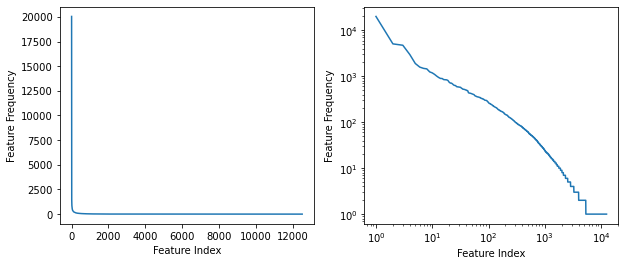

In [14]:
# get feature size
print("stemmed feature size:", len(stemmed_feat_cnt))

# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f,cnt in stemmed_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one
plt.subplot(1,2,1)
# draw linear lines
plt.plot(range(1, len(stemmed_feat_cnt)+1), 
        [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(range(1, len(stemmed_feat_cnt)+1), 
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10)
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

Similarly, we can check the 2-gram features.

2-gram feature size: 101412


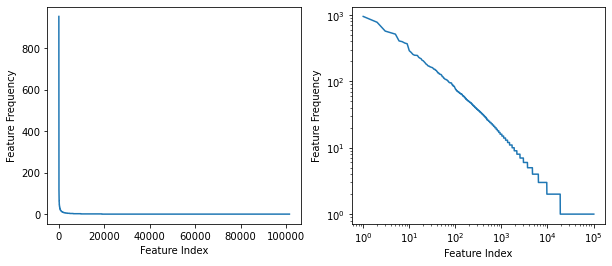

In [15]:
# get the feature size
print("2-gram feature size:", len(bi_gram_feat_cnt))

# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f,cnt in bi_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(bi_gram_feat_cnt)+1), 
        [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys])
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.subplot(1,2,2)
plt.loglog(range(1, len(bi_gram_feat_cnt)+1), 
            [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10)
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

3-gram features are much sparser.

3-gram feature size: 166549


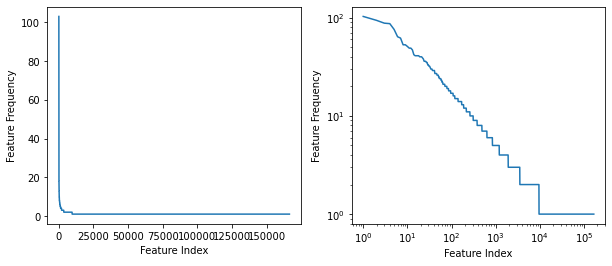

In [16]:
# get the feature size
print("3-gram feature size:", len(tri_gram_feat_cnt))

# then, get the sorted features by the frequency
tri_gram_feat_keys = [f for f,cnt in tri_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(tri_gram_feat_cnt)+1), 
        [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys])
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.subplot(1,2,2)
plt.loglog(range(1, len(tri_gram_feat_cnt)+1), 
            [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10)
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

And 4-gram models.

4-gram feature size: 182575


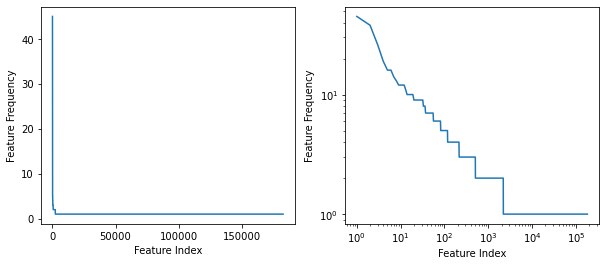

In [17]:
# get the feature size
print("4-gram feature size:", len(four_gram_feat_cnt))

# then, get the sorted features by the frequency
four_gram_feat_keys = [f for f,cnt in four_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(four_gram_feat_cnt)+1), 
        [four_gram_feat_cnt[f] for f in four_gram_feat_keys])
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.subplot(1,2,2)
plt.loglog(range(1, len(four_gram_feat_cnt)+1), 
            [four_gram_feat_cnt[f] for f in four_gram_feat_keys],
           basex=10, basey=10)
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

We can also put them together.

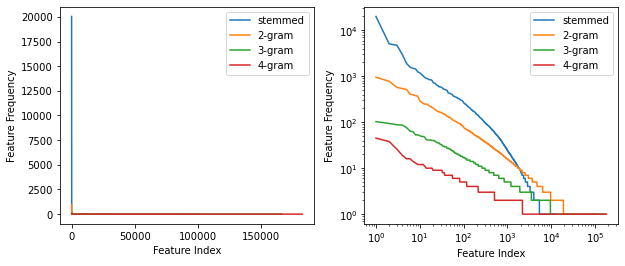

In [18]:
# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# put the four linear lines together
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
         label="stemmed")
plt.plot(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
         label="2-gram")
plt.plot(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
         label="3-gram")
plt.plot(range(1, len(four_gram_feat_cnt)+1),
         [four_gram_feat_cnt[f] for f in four_gram_feat_keys],
         label="4-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10, label="stemmed")
plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10, label="2-gram")
plt.loglog(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10, label="3-gram")
plt.loglog(range(1, len(four_gram_feat_cnt)+1),
         [four_gram_feat_cnt[f] for f in four_gram_feat_keys],
           basex=10, basey=10, label="4-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.show()

As we can see, linear lines are not suitable to analyze. From the log view, we can find more than 80% features are low-frequent.
And only about 3000 features occur no less than 10 times.

In [19]:
print("stemmed features > 10:",
      len([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]))
print("2-gram features > 10:",
      len([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]))
print("3-gram features > 10:",
      len([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]))
print("4-gram features > 10:",
      len([f for f, cnt in four_gram_feat_cnt.items() if cnt > 10]))

stemmed features > 10: 1770
2-gram features > 10: 1702
3-gram features > 10: 260
4-gram features > 10: 13


And we can check the top 10 features.

In [20]:
print("stemmed features top 10:",
      stemmed_feat_keys[:10])
print("2-gram features top 10:",
      bi_gram_feat_keys[:10])
print("3-gram features top 10:",
      tri_gram_feat_keys[:10])
print("4-gram features top 10:",
      four_gram_feat_keys[:10])

stemmed features top 10: ['.', 'hotel', 'room', 'stay', 'great', "n't", 'locat', 'staff', 'night', 'nice']
2-gram features top 10: ['. room', 'hotel .', '. hotel', 'room .', 'stay .', '. staff', "did n't", '. stay', '. not', 'san francisco']
3-gram features top 10: [". did n't", 'san francisco .', '. staff friendli', '. room clean', 'staff friendli help', '. room small', 'friendli help .', '. definit stay', 'pike place market', 'definit stay .']
4-gram features top 10: ['staff friendli help .', '. staff friendli help', '. definit stay .', 'pike place market .', 'great hotel great locat', 'hotel great locat .', 'block pike place market', '. staff help friendli', 'staff help friendli .', "ca n't beat locat"]


## Cross Validation and Ensemble

We can use cross validation with the ensemble technique to reduce overfitting as well as the randomness issue.

In [21]:
# n_fold document: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
n_fold = 3
np.random.seed(0)
# create the n-fold generator
skf = StratifiedKFold(n_fold, shuffle=True)

clfs_1 = list()
valid_acc_list = list()
for k, (train_idx, valid_idx) in enumerate(
    skf.split(train_feats_matrix.toarray(), train_labels)):
    # build the classifier and train
    clf = GaussianNB()
    
    clf.fit(train_feats_matrix.toarray()[train_idx], train_labels.values[train_idx])
    
    #Get the predictions of the classifier
    train_pred = clf.predict(train_feats_matrix.toarray()[train_idx])
    valid_pred = clf.predict(train_feats_matrix.toarray()[valid_idx])

    #Compute accuracy scores
    train_score = accuracy_score(train_labels.values[train_idx], train_pred)
    valid_score = accuracy_score(train_labels.values[valid_idx], valid_pred)
    
    print("training accuracy", train_score)
    print("validation accuracy", valid_score)
    
    clfs_1.append(clf)
    valid_acc_list.append(valid_score)
    
print('Average validation score: ', sum(valid_acc_list)/len(valid_acc_list))

training accuracy 0.886721680420105
validation accuracy 0.44677661169415295
training accuracy 0.8792198049512379
validation accuracy 0.4257871064467766
training accuracy 0.9220389805097451
validation accuracy 0.4264264264264264
Average validation score:  0.43299671485578534


We can try another model with different input features

In [22]:
# build a set containing each unique feature which has appeared more than 10 times in the training set
new_feats_set = set()

# add those stem features which occurs more than 10 times into the feature set.
new_feats_set.update([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]) 
    
# add those 2-gram features which occurs more than 10 times into the feature set.
new_feats_set.update([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]) 

print("Size of new features:", len(new_feats_set))
# build a mapping from features to indices
new_feats_dict = dict(zip(new_feats_set, range(len(new_feats_set))))



# build the feature list
new_train_feats = list()
for i in range(len(train_ids)):
    # concatenate the stemmed token list and the 2_gram list together
    new_train_feats.append(train_stemmed[i] + train_2_gram[i] )
new_test_feats = list()
for i in range(len(test_ids)):
    # concatenate the stemmed token list and the 2_gram list together
    new_test_feats.append(test_stemmed[i] + test_2_gram[i])

# build the feats_matrix in a similar way as described above
new_train_feats_matrix = coo_matrix(np.vstack([get_onehot_vector(f, new_feats_dict) for f in new_train_feats]))
new_test_feats_matrix = coo_matrix(np.vstack([get_onehot_vector(f, new_feats_dict) for f in new_test_feats]))



Size of new features: 3472


In [23]:
n_fold = 3
# create the n-fold generator
skf = StratifiedKFold(n_fold, shuffle=True)

clfs_2 = list()
valid_acc_list = list()

for k, (train_idx, valid_idx) in enumerate(
    skf.split(new_train_feats_matrix.toarray(), train_labels)):
    # build the classifier and train
    clf = GaussianNB()
    
    clf.fit(new_train_feats_matrix.toarray()[train_idx], train_labels.values[train_idx])
    
    #Get the predictions of the classifier
    train_pred = clf.predict(new_train_feats_matrix.toarray()[train_idx])
    valid_pred = clf.predict(new_train_feats_matrix.toarray()[valid_idx])

    #Compute accuracy scores
    train_score = accuracy_score(train_labels.values[train_idx], train_pred)
    valid_score = accuracy_score(train_labels.values[valid_idx], valid_pred)
    
    print("training accuracy", train_score)
    print("validation accuracy", valid_score)
    
    clfs_2.append(clf)
    valid_acc_list.append(valid_score)
    
print('Average validation score: ', sum(valid_acc_list)/len(valid_acc_list))

training accuracy 0.8912228057014253
validation accuracy 0.43778110944527737
training accuracy 0.8994748687171793
validation accuracy 0.41529235382308843
training accuracy 0.9085457271364318
validation accuracy 0.4339339339339339
Average validation score:  0.4290024657340999


Since the classifier with the first type of features has better validation score, we choose to do the ensemble on the corresponding instances.

In [24]:
# compute the sum of test probabilities and return the classes with largest sums
test_prob = None
for i, clf in enumerate(clfs_1):
    if(i==0):
        test_prob = clf.predict_proba(test_feats_matrix.toarray())
    else:
        test_prob += clf.predict_proba(test_feats_matrix.toarray())
        
test_pred = test_prob.argmax(axis=1) + 1
print("Ensemble", "test accuracy", accuracy_score(test_labels, test_pred))

Ensemble test accuracy 0.4425
